# 机器学习实验二：基于winequality-white.csv的回归模型分析
- **姓名：刘伟**
- **学号：2013029**
- **专业：物联网工程**

## 基本要求：
### 将数据集winequality-white.csv按照4:1划分成训练集和测试集
- 构造线性回归模型，并采用**批量梯度下降**和**随机梯度下降**进行优化；输出训练集和测试集的均方误差(MSE)，画出MSE收敛曲线。
- 对于**批量梯度下降**和**随机梯度下降**，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

### 特别需要注意：
- 划分数据集时尽可能保持**数据分布的一致性**，保持样本类别比例相似。
- 需要对数据集进行一定的预处理。

## 导入winequality-white.csv数据

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("D:\\NKU\\Semester_3\\机器学习\\winequality-white.csv")
# 查看数据
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 


## 先对数据集整体平均归一化，再进行抽样划分：采取分层随机抽样的方法

In [2]:
# 数据预处理
# 采用 平均归一化 的方法  ： X'=(X-μ)/(X_MAX-X_MIN)

def Mean_normalization(X):
    X = (X-np.mean(X,0))/(np.max(X,0)-np.min(X,0))
    return X

# 取出所有的 Xi 数据，做预处理
data_x = data.iloc[:,0:-1]

# 平均归一化
data_x = Mean_normalization(data_x)
# print(data_x.head())

# 补全原先的quality 预处理后的样本数据
data_x['quality'] = data['quality']
# print(data_x.head())

In [3]:
# 按照不同的quality进行分组 group
quality_data = data_x.groupby('quality')

# 存放每个quality种类下的数据
Q_data = []
for i in quality_data:
#     print(i[1])
    Q_data.append(i[1])
    
# 质量分布从 3-9 一共有 7 个种类
# 每个质量品质下的数据项分别为：20 163 1457 2198 880 175 5
print(quality_data['quality'].value_counts())

quality  quality
3        3            20
4        4           163
5        5          1457
6        6          2198
7        7           880
8        8           175
9        9             5
Name: quality, dtype: int64


In [4]:
# 分层数据后的
# 特征集合X 标签集合Y
X = []  
Y = []
for i in range(0,7,1):
    x = Q_data[i].iloc[:, 0:-1]
    X.append(x)
    y = Q_data[i].iloc[:,11]
    Y.append(y)

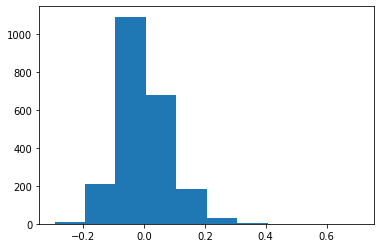

In [5]:
# 可视化归一后的特征
import matplotlib.pyplot as plt
plt.hist(X[3]["fixed acidity"])
plt.show()

In [6]:
# 进行数据分割 按照 4：1 进行随即分割
X_train = np.empty(shape=(0,11))
Y_train = np.empty(shape=(0,))
X_test = np.empty(shape=(0,11))
Y_test = np.empty(shape=(0,))

for index in range(0,7,1):
    # 取出每类数据 X Y
    x_i = np.array(X[index])
    y_i = np.array(Y[index])
    
    # 生成随机序列
    row_indices = np.random.permutation(x_i.shape[0])
    # 4：1 的分割线
    split_num = int((row_indices.shape[0])*0.8)
    
    # 取出每一个quality类别下 80% 的训练数据
    x_i_train = x_i[row_indices[0:split_num],:]
    # 合并所有类别的训练数据
    X_train = np.concatenate((X_train,x_i_train),axis=0)
    
    # 取出每一个quality类别下 80% 的训练数据对应的 标签
    y_i_train = y_i[row_indices[0:split_num]]
    # 合并标签数据
    Y_train = np.concatenate((Y_train,y_i_train),axis=0)
    
    # 取出每一个quality类别下 20% 的测试数据
    x_i_test = x_i[row_indices[split_num:],:]
    # 合并所有类别的测试数据
    X_test = np.concatenate((X_test,x_i_test),axis=0)
    
    # 取出每一个quality类别下 20% 的训练数据对应的 标签
    y_i_test = y_i[row_indices[split_num:]]
    # 合并标签数据
    Y_test = np.concatenate((Y_test,y_i_test),axis=0)

    
# print(X_train.shape)
# print(X_train[:10])
# print(X_test.shape)
# print(X_test[:10])
# print(Y_train.shape)
# print(Y_train[:20])
# print(Y_test.shape)
# print(Y_test[:20])


## 批量梯度下降
## 随机梯度下降

In [7]:
# 在进行正式计算之前 把 X 数据增加一个维度
# 减少计算量以及复杂度
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1)
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1)
# print(X_train.shape)
# print(X_train[:10])
# print(Y_train.shape)

# reshape Y的维度 确保矩阵做运算的正确性
Y_train = Y_train.reshape((Y_train.shape[0],1))
print(Y_train.shape)
Y_test = Y_test.reshape((Y_test.shape[0],1))
print(Y_test.shape)

(3917, 1)
(981, 1)


In [8]:
# 批量梯度下降

def BGD(X,Y,epoch,theta,learning_rate,Print):
    # 迭代次数
    iter_count = 0
    
    # 训练数据总量
    m = X.shape[0]
    
    # 记录每次迭代的代价值
    costs = []
    
    while iter_count < epoch:
        iter_count = iter_count+1
        
        # 计算当前 theta 参数的 预测特征 Y
        y_pred = np.dot(X,theta)
        
        # 按公式 计算代价值
        cost = np.sum(np.power((Y - y_pred),2))/m
        
        # 反向传播 学习更新theta 参数
        theta = theta - 2*(learning_rate/m)*np.dot(X.T,(y_pred - Y))
        
        if iter_count % 100 == 0:
            costs.append(cost)
            if Print:
                print(learning_rate)
                print("迭代的次数: %i ， 误差值： %f" % (iter_count,cost))
                
            # 学习率缩放 
            if iter_count % 1000 == 0:
                learning_rate = learning_rate * (1-int(iter_count//1000)*0.4)
    
    return theta,costs

### 随机梯度下降较批量梯度下降而言，它的每一轮参数的更新速度大大加快，但可能会收敛到局部最优。（由于单个样本并不能代表全体样本的趋势

In [9]:
# 随机梯度下降

def SGD(X,Y,epoch,theta,learning_rate,Print):
    # 迭代次数
    iter_count = 0
    
    # 训练数据总量
    m = X.shape[0]
    
    # 记录每次迭代的代价值
    costs = []
    
    while iter_count < epoch:
        iter_count = iter_count+1
        
        # 生成随机数 作为每次更新学习时 选择的样本号
        rand_i = np.random.randint(m)
        
        # 计算当前 theta 参数的 预测特征 Y
        y_pred = np.dot(X,theta)
        
        # 按公式 计算代价值
        cost = np.sum(np.power((Y - y_pred),2))/m
        
        # 随机梯度下降
        # 更新参数时，不用全体样本 随机挑选一个
        theta = theta - 2*(learning_rate)*np.dot((X[rand_i].T).reshape(-1,1),(y_pred[rand_i] - Y[rand_i]).reshape(-1,1))
        
        if iter_count % 100 == 0:
            costs.append(cost)
            if Print:
                print(learning_rate)
                print("迭代的次数: %i ， 误差值： %f" % (iter_count,cost))
                
            # 学习率缩放 
            if iter_count % 1000 == 0:
                learning_rate = learning_rate * (1-int(iter_count//1000)*0.04)
    
    return theta,costs    

0.03
迭代的次数: 100 ， 误差值： 0.665647
0.03
迭代的次数: 200 ， 误差值： 0.654501
0.03
迭代的次数: 300 ， 误差值： 0.645736
0.03
迭代的次数: 400 ， 误差值： 0.638454
0.03
迭代的次数: 500 ， 误差值： 0.632257
0.03
迭代的次数: 600 ， 误差值： 0.626889
0.03
迭代的次数: 700 ， 误差值： 0.622176
0.03
迭代的次数: 800 ， 误差值： 0.617999
0.03
迭代的次数: 900 ， 误差值： 0.614270
0.03
迭代的次数: 1000 ， 误差值： 0.610922
0.018
迭代的次数: 1100 ， 误差值： 0.609063
0.018
迭代的次数: 1200 ， 误差值： 0.607325
0.018
迭代的次数: 1300 ， 误差值： 0.605687
0.018
迭代的次数: 1400 ， 误差值： 0.604143
0.018
迭代的次数: 1500 ， 误差值： 0.602685
0.018
迭代的次数: 1600 ， 误差值： 0.601307
0.018
迭代的次数: 1700 ， 误差值： 0.600004
0.018
迭代的次数: 1800 ， 误差值： 0.598771
0.018
迭代的次数: 1900 ， 误差值： 0.597604
0.018
迭代的次数: 2000 ， 误差值： 0.596497
0.003599999999999999
迭代的次数: 2100 ， 误差值： 0.596274
0.003599999999999999
迭代的次数: 2200 ， 误差值： 0.596063
0.003599999999999999
迭代的次数: 2300 ， 误差值： 0.595853
0.003599999999999999
迭代的次数: 2400 ， 误差值： 0.595645
0.003599999999999999
迭代的次数: 2500 ， 误差值： 0.595440
0.003599999999999999
迭代的次数: 2600 ， 误差值： 0.595237
0.003599999999999999
迭代的次数: 2700 ， 误差值： 0.595

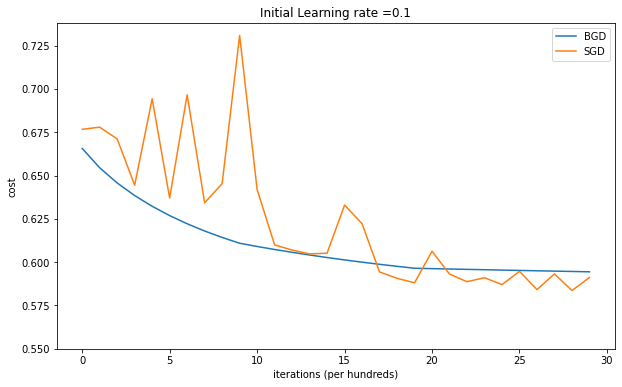

In [10]:
# 随机初始化 theta 参数
theta = np.random.randn(X_train.shape[1],1)

theta1,costs1 = BGD(X_train,Y_train,3000,theta,0.03,True)
print("===============================================================")
theta2,costs2 = SGD(X_train,Y_train,3000,theta,0.03,True)
print("===============================================================")

plt.figure(figsize=(10,6))
plt.plot(costs1)
plt.plot(costs2)
plt.ylabel('cost')
plt.ylim(0.55)
plt.xlabel('iterations (per hundreds)')
plt.title("Initial Learning rate =" + str(0.1))
plt.legend(['BGD','SGD'])
plt.show()

In [11]:
# 针对不同的初始学习率，分析最佳学习率的设定
theta = np.random.randn(X_train.shape[1],1)
learning_rates = [0.1,0.05,0.01,0.009,0.008,0.007,0.006,0.005]

# 记录俩种方法在不同学习率下的 代价值变化
BGD_costs = []
SGD_costs = []

for i in learning_rates:
    theta1,costs_1 = BGD(X_train,Y_train,3000,theta,i,False)
    theta2,costs_2 = SGD(X_train,Y_train,3000,theta,i,False)
    BGD_costs.append(costs_1)
    SGD_costs.append(costs_2)

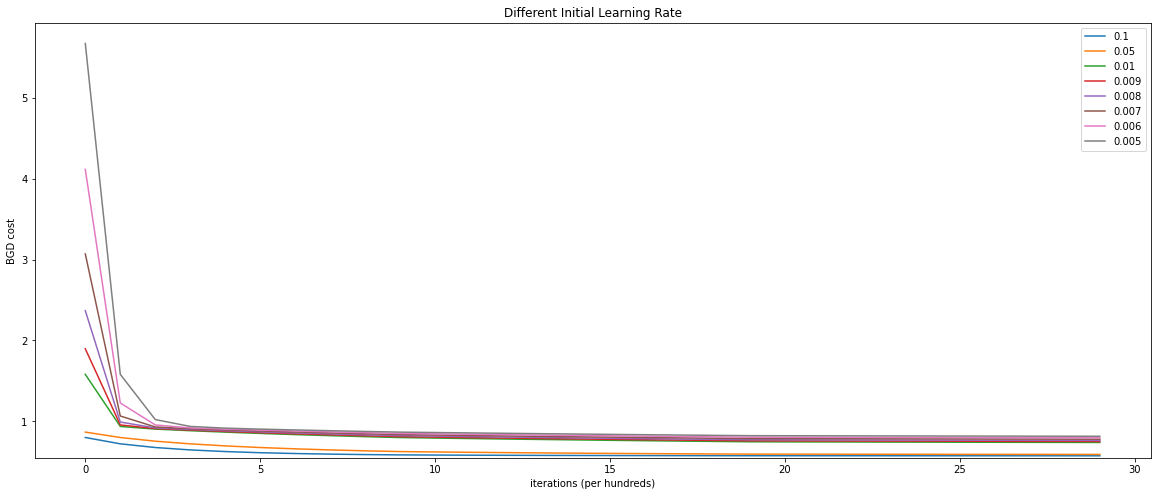

In [12]:
plt.figure(figsize=(20,8))
for C in BGD_costs:
    plt.plot(C)
plt.ylabel('BGD cost')
plt.ylim(0.55)
plt.xlabel('iterations (per hundreds)')
plt.title("Different Initial Learning Rate")
plt.legend(learning_rates)
plt.show()

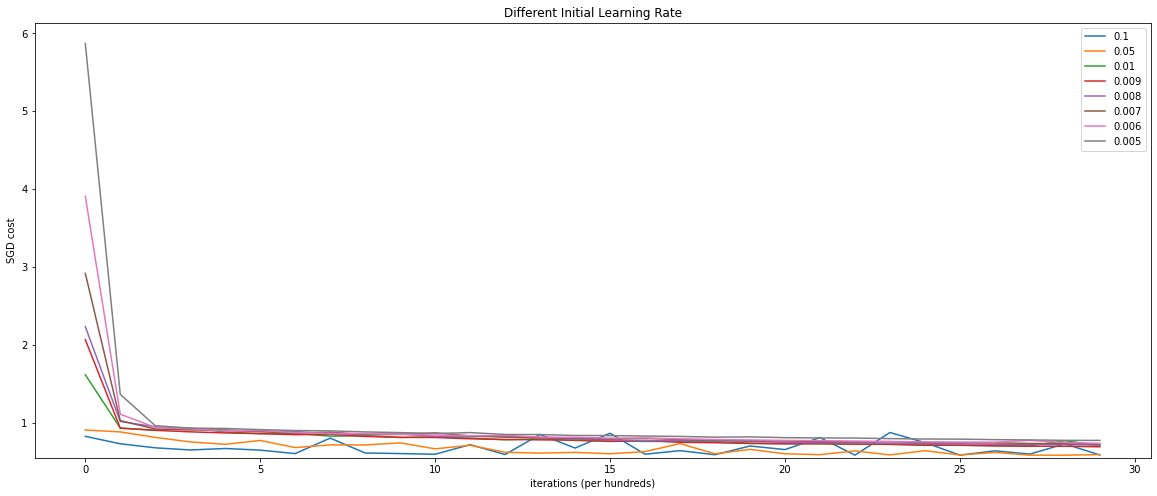

In [13]:
plt.figure(figsize=(20,8))
for C in SGD_costs:
    plt.plot(C)
plt.ylabel('SGD cost')
plt.ylim(0.55)
plt.xlabel('iterations (per hundreds)')
plt.title("Different Initial Learning Rate")
plt.legend(learning_rates)
plt.show()

## 中级要求：
### 探究回归模型在机器学习和统计学上的差异
- 回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。从回归模型的角度更加充分地理解机器学习和统计学的区别。

**区别**：
- 在机器学习中，我们是对模型加以训练。给其已知的样本数据集，目的是让其能够更好的完成对未知数据的预测功能；**机器学习的最终目的在于获得基于测试数据集的模型最佳性能**；
- 在统计学习中，我们是对已知的全部数据加以计算拟合，寻求一条均方误差最小的直线，让其尽可能的更接近所有的数据点。统计学习中无训练与测试数据集这一说法，其研究的重心在于**已知数据与结果变量之间的关系**，其**不在意拟合直线对于未来不知的数据的预测能力**；
- 机器学习**本身就不认为数据符合某一种特定的假设分布，默认数据的关系本身是复杂的，x对于y的解释是不确定的**。机器学习的线性回归，是首先将数据划分为训练集和测试集，通过对训练集的拟合，再通过测试集检验，获得的参数是使得测试集表现最好的参数集合。
- 统计模型，最关注参数的稳定性和残差的变化特征是否表现为匹配数据的假设分布。通过最小化拟合值与实际观测值的方差获得线性模型具体参数，仅用于分析已有的数据，**止步于统计推断和评估参数的稳定性，很少用于预测新的数据（即使预测，也更多在于分析变量对于数据的解释能力）**。
- 只是因为二者使用的概率理论是一样的就将二者是为一致是不正确、错误的！

## 高级要求：
### 编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差

In [14]:
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
import matplotlib.ticker as mtick

def theta(X, Y, lamba):  # 设置岭系数

    # 按公式计算各个变量
    xTx = np.mat(np.dot(X.T,X))  
    xTx_L = xTx + np.eye(X.shape[1]) * lamba  # 岭回归求解的括号的部分
    xTx_L = np.mat(xTx_L)
    theta = xTx_L.I * X.T * Y  #求解岭回归得到的模型参数
    return theta

In [15]:
theta3 = theta(X_train,Y_train,0.1)
# 计算 平均训练误差 与 平均测试误差
cost_train = np.sum(np.power((Y_train - np.dot(X_train,theta3)),2))/X_train.shape[0]
print(cost_train)
cost_test = np.sum(np.power((Y_test - np.dot(X_test,theta3)),2))/X_test.shape[0]
print(cost_test)

0.5640783415027397
0.563042084459864


In [16]:
# 对不同的 lambdaλ值进行 平均训练误差 与 平均测试误差 的比较
C_train = []
C_test = []
x_lambda = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5]
for i in x_lambda:
    theta_i = theta(X_train,Y_train,i)
    C_train.append(np.sum(np.power((Y_train - np.dot(X_train,theta_i)),2))/X_train.shape[0])
    C_test.append(np.sum(np.power((Y_test - np.dot(X_test,theta_i)),2))/X_test.shape[0])

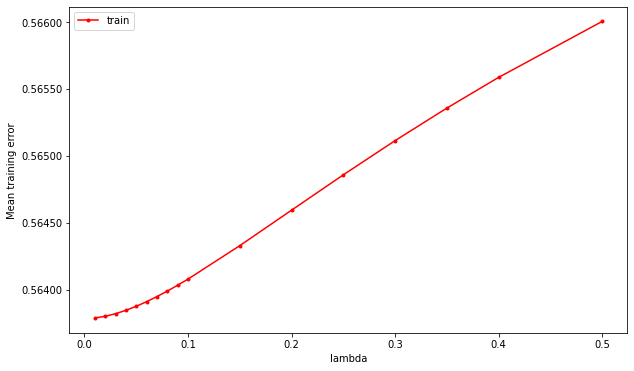

In [17]:
# 平均训练误差 在不同 岭系数 的变化曲线
plt.figure(figsize=(10,6))
plt.plot(x_lambda,C_train,color='r',label="train", marker=".", linestyle="-") 
plt.xlabel("lambda")
plt.ylabel("Mean training error")
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))
plt.legend()
plt.show()

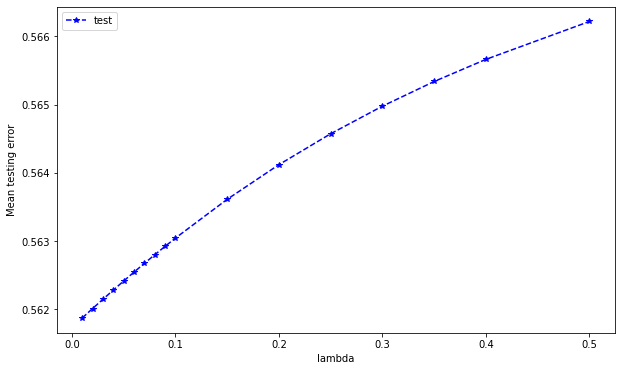

In [18]:
# 平均测试误差 在不同 岭系数 的变化曲线
plt.figure(figsize=(10,6))
plt.plot(x_lambda,C_test,color='b',label="test", marker="*", linestyle="--")
plt.xlabel("lambda")
plt.ylabel("Mean testing error")
plt.legend()
plt.show()